# Population Estimation Pipeline

## Setup

### General imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import tensorflow as tf
from osgeo import gdal, osr, ogr
from tifffile import imread
from tqdm import tqdm

In [3]:
from functions.visualization import to_img, display_pair, get_tiles, get_tiles_df, get_table

### Parameters

In [4]:
SEED = 42
np.random.seed(SEED)
prng = np.random.RandomState(SEED)

In [5]:
tiles_path = './survey_tiles/'

#### Survey rasterization

In [6]:
survey_data_path = './Mozambique Dataset 1/Mozambique samples/'
boa_srs_path = './Mozambique Dataset 1/Mozambique empty grids/BOA_adm_gridcentroids-100m.shp'
mgd_srs_path = './Mozambique Dataset 1/Mozambique empty grids/MGD_adm_gridcentroids-100m.shp'
boa_survey_path = './data/pop/boa_pop.tif'
mgd_survey_path = './data/pop/mgd_pop.tif'

#### Building footprint estimation

In [7]:
rerun_footprints = False
model_paths = ['./spacenet/models/model_1_old/','./spacesur/dataset_2/models/model_1/','./spacesur/dataset_2/models/model_2/']

### Preprocessing

In [8]:
rerun_preprocessing = False

#### Population estimation

In [9]:
features = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3', 'landsat_b4', 'landsat_b5', 
                     'landsat_b6', 'landsat_b7', 'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
                     'open_forest', 'shrubs', 'hb_veg', 'cropland', 'urban', 'building_area_ss2_2', 
                     'landsat_b0_context_3x3', 'landsat_b1_context_3x3',
                     'landsat_b2_context_3x3', 'landsat_b3_context_3x3', 'landsat_b4_context_3x3', 'landsat_b5_context_3x3',
                     'landsat_b6_context_3x3', 'landsat_b7_context_3x3', 'landsat_b8_context_3x3', 'landsat_b9_context_3x3',
                     'ndvi_context_3x3', 'ndwi_context_3x3', 'ntl_context_3x3', 'hrsl_context_3x3', 'open_forest_context_3x3', 
                      'shrubs_context_3x3', 'hb_veg_context_3x3', 'cropland_context_3x3', 'urban_context_3x3', 'building_area_ss2_2_context_3x3',
                     'landsat_b0_context_5x5', 'landsat_b1_context_5x5', 'landsat_b2_context_5x5', 'landsat_b3_context_5x5',
                     'landsat_b4_context_5x5', 'landsat_b5_context_5x5', 'landsat_b6_context_5x5', 'landsat_b7_context_5x5',
                     'landsat_b8_context_5x5', 'landsat_b9_context_5x5', 'ndvi_context_5x5', 'ndwi_context_5x5', 'ntl_context_5x5',
                     'hrsl_context_5x5', 'open_forest_context_5x5',
                     'shrubs_context_5x5', 'hb_veg_context_5x5',
                     'cropland_context_5x5', 'urban_context_5x5', 'building_area_ss2_2_context_5x5'])

In [10]:
len(features)

60

In [11]:
features_public = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3', 'landsat_b4', 'landsat_b5', 
                     'landsat_b6', 'landsat_b7', 'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
                     'open_forest', 'shrubs', 'hb_veg', 'cropland', 'urban', 
                     'landsat_b0_context_3x3', 'landsat_b1_context_3x3',
                     'landsat_b2_context_3x3', 'landsat_b3_context_3x3', 'landsat_b4_context_3x3', 'landsat_b5_context_3x3',
                     'landsat_b6_context_3x3', 'landsat_b7_context_3x3', 'landsat_b8_context_3x3', 'landsat_b9_context_3x3',
                     'ndvi_context_3x3', 'ndwi_context_3x3', 'ntl_context_3x3', 'hrsl_context_3x3', 'open_forest_context_3x3', 
                      'shrubs_context_3x3', 'hb_veg_context_3x3', 'cropland_context_3x3', 'urban_context_3x3',
                     'landsat_b0_context_5x5', 'landsat_b1_context_5x5', 'landsat_b2_context_5x5', 'landsat_b3_context_5x5',
                     'landsat_b4_context_5x5', 'landsat_b5_context_5x5', 'landsat_b6_context_5x5', 'landsat_b7_context_5x5',
                     'landsat_b8_context_5x5', 'landsat_b9_context_5x5', 'ndvi_context_5x5', 'ndwi_context_5x5', 'ntl_context_5x5',
                     'hrsl_context_5x5', 'open_forest_context_5x5',
                     'shrubs_context_5x5', 'hb_veg_context_5x5',
                     'cropland_context_5x5', 'urban_context_5x5'])

In [12]:
len(features_public)

57

In [13]:
features_public_spacenet = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3', 'landsat_b4', 'landsat_b5', 
                     'landsat_b6', 'landsat_b7', 'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
                     'open_forest', 'shrubs', 'hb_veg', 'cropland', 'urban', 'building_area_sn', 
                     'landsat_b0_context_3x3', 'landsat_b1_context_3x3',
                     'landsat_b2_context_3x3', 'landsat_b3_context_3x3', 'landsat_b4_context_3x3', 'landsat_b5_context_3x3',
                     'landsat_b6_context_3x3', 'landsat_b7_context_3x3', 'landsat_b8_context_3x3', 'landsat_b9_context_3x3',
                     'ndvi_context_3x3', 'ndwi_context_3x3', 'ntl_context_3x3', 'hrsl_context_3x3', 'open_forest_context_3x3', 
                      'shrubs_context_3x3', 'hb_veg_context_3x3', 'cropland_context_3x3', 'urban_context_3x3', 'building_area_sn_context_3x3',
                     'landsat_b0_context_5x5', 'landsat_b1_context_5x5', 'landsat_b2_context_5x5', 'landsat_b3_context_5x5',
                     'landsat_b4_context_5x5', 'landsat_b5_context_5x5', 'landsat_b6_context_5x5', 'landsat_b7_context_5x5',
                     'landsat_b8_context_5x5', 'landsat_b9_context_5x5', 'ndvi_context_5x5', 'ndwi_context_5x5', 'ntl_context_5x5',
                     'hrsl_context_5x5', 'open_forest_context_5x5',
                     'shrubs_context_5x5', 'hb_veg_context_5x5',
                     'cropland_context_5x5', 'urban_context_5x5', 'building_area_sn_context_5x5'])

In [14]:
# features_3x3 = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3', 'landsat_b4', 'landsat_b5', 
#                      'landsat_b6', 'landsat_b7', 'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
#                      'open_forest', 'shrubs', 'hb_veg', 'cropland', 'urban', 'building_area_ss2_3', 
#                      'landsat_b0_context_3x3', 'landsat_b1_context_3x3',
#                      'landsat_b2_context_3x3', 'landsat_b3_context_3x3', 'landsat_b4_context_3x3', 'landsat_b5_context_3x3',
#                      'landsat_b6_context_3x3', 'landsat_b7_context_3x3', 'landsat_b8_context_3x3', 'landsat_b9_context_3x3',
#                      'ndvi_context_3x3', 'ndwi_context_3x3', 'ntl_context_3x3', 'hrsl_context_3x3', 'open_forest_context_3x3', 
#                       'shrubs_context_3x3', 'hb_veg_context_3x3', 'cropland_context_3x3', 'urban_context_3x3', 'building_area_ss2_1_context_3x3'])

In [15]:
# features_public_3x3 = np.array(['landsat_b0', 'landsat_b1', 'landsat_b2', 'landsat_b3', 'landsat_b4', 'landsat_b5', 
#                      'landsat_b6', 'landsat_b7', 'landsat_b8', 'landsat_b9', 'ndvi', 'ndwi', 'ntl', 'hrsl',
#                      'open_forest', 'shrubs', 'hb_veg', 'cropland', 'urban', 
#                      'landsat_b0_context_3x3', 'landsat_b1_context_3x3',
#                      'landsat_b2_context_3x3', 'landsat_b3_context_3x3', 'landsat_b4_context_3x3', 'landsat_b5_context_3x3',
#                      'landsat_b6_context_3x3', 'landsat_b7_context_3x3', 'landsat_b8_context_3x3', 'landsat_b9_context_3x3',
#                      'ndvi_context_3x3', 'ndwi_context_3x3', 'ntl_context_3x3', 'hrsl_context_3x3', 'open_forest_context_3x3', 
#                       'shrubs_context_3x3', 'hb_veg_context_3x3', 'cropland_context_3x3', 'urban_context_3x3'])

In [16]:
features_spacesur_only = np.array(['building_area_ss2_2','building_area_ss2_2_context_3x3','building_area_ss2_2_context_5x5'])

In [17]:
features_spacenet_only = np.array(['building_area_sn','building_area_sn_context_3x3','building_area_sn_context_5x5'])

In [18]:
features_embeddings = np.array([f'embd_{i}' for i in range(2048)])

In [19]:
print(len(features))

60


In [20]:
target = 'pop'
context_sizes = [3,5]
log = True

## Rasterize survey

In [21]:
from functions.survey import df_to_raster, display_surveys, get_extent

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


### Load data

In [22]:
df_raw_boa = pd.read_stata(survey_data_path + 'sample_boa.dta')
df_raw_mgd = pd.read_stata(survey_data_path + 'sample_mgd.dta')

### Rasterize

In [23]:
# Compute and export geotiff population rasters from survey data
df_to_raster(df_raw_boa,boa_survey_path,boa_srs_path,'members_n')
df_to_raster(df_raw_mgd,mgd_survey_path,mgd_srs_path,'members_n')

In [24]:
# Compute and export geotiff building count rasters from survey data
df_to_raster(df_raw_boa,'./data/pop/boa_count.tif',boa_srs_path,'count_buildings')
df_to_raster(df_raw_mgd,'./data/pop/mgd_count.tif',mgd_srs_path,'count_buildings')

In [25]:
pop_boa = imread(boa_survey_path)
pop_mgd = imread(mgd_survey_path)

In [26]:
print(pop_boa.shape)
print(pop_mgd.shape)

(362, 166)
(649, 545)


## Estimate building footprints

In [27]:
from functions.footprints.prediction import load_model, estimate_footprints

In [28]:
if rerun_footprints:
    estimate_footprints('boa',pop_boa,'./maxar_boa/',model_paths,context_sizes)
    estimate_footprints('mgd',pop_mgd,'./maxar_mgd/',model_paths,context_sizes)

In [29]:
# import os
# xs = []
# ys = []
# for f in os.listdir('./spacesur/dataset_3/models/model_1/pred/boa/'):
#     idxs = f[:-4].split('_')
#     xs.append(int(idxs[1]))
#     ys.append(int(idxs[0]))
# xs_survey = []
# ys_survey = []
# for y in range(pop_boa.shape[0]):
#     for x in range(pop_boa.shape[1]):
#         if pop_boa[y,x] > 0:
#             xs_survey.append(x)
#             ys_survey.append(y)
# f, ax = plt.subplots(figsize=(20,20))
# plt.scatter(xs,ys,s=4)
# plt.scatter(xs_survey,ys_survey,s=4,c='red')
# # Square the axes to ensure a 45 degree line
# ylim = ax.get_ylim()
# xlim = ax.get_xlim()

# # Find the range that captures all data
# bounds = (min(ylim[0], xlim[0]), max(ylim[1], xlim[1]))

# # Reset the limits
# ax.set_xlim(bounds)
# ax.set_ylim(bounds)

# # Ensure the aspect ratio is square
# ax.set_aspect("equal", adjustable="box")

## Preprocessing

In [30]:
from functions.data import *
from functions.preprocessing import *

### Load data and construct dataset

In [31]:
if rerun_preprocessing:
    preprocess_data('./data/preprocessing.json')

In [32]:
df = build_dataset('./data/dataset.json')

### Remove outliers

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
display(df)

,x,y,building_area_sn,building_area_ss2_1,building_area_ss2_2,building_area_ss3_1,closed_forest,crop,cropland,hb_veg,hb_waste,hrsl,landsat_b0,landsat_b1,landsat_b2,landsat_b3,landsat_b4,landsat_b5,landsat_b6,landsat_b7,landsat_b8,landsat_b9,moss,ndvi,ndwi,no_data,ntl,open_forest,sea,shrubs,snow,sparse,urban,water,building_area_sn_context_3x3,building_area_ss2_1_context_3x3,building_area_ss2_2_context_3x3,building_area_ss3_1_context_3x3,closed_forest_context_3x3,crop_context_3x3,cropland_context_3x3,hb_veg_context_3x3,hb_waste_context_3x3,hrsl_context_3x3,landsat_b0_context_3x3,landsat_b1_context_3x3,landsat_b2_context_3x3,landsat_b3_context_3x3,landsat_b4_context_3x3,landsat_b5_context_3x3,landsat_b6_context_3x3,landsat_b7_context_3x3,landsat_b8_context_3x3,landsat_b9_context_3x3,moss_context_3x3,ndvi_context_3x3,ndwi_context_3x3,no_data_context_3x3,ntl_context_3x3,open_forest_context_3x3,sea_context_3x3,shrubs_context_3x3,snow_context_3x3,sparse_context_3x3,urban_context_3x3,water_context_3x3,building_area_sn_context_5x5,building_area_ss2_1_context_5x5,building_area_ss2_2_context_5x5,building_area_ss3_1_context_5x5,closed_forest_context_5x5,crop_context_5x5,cropland_context_5x5,hb_veg_context_5x5,hb_waste_context_5x5,hrsl_context_5x5,landsat_b0_context_5x5,landsat_b1_context_5x5,landsat_b2_context_5x5,landsat_b3_context_5x5,landsat_b4_context_5x5,landsat_b5_context_5x5,landsat_b6_context_5x5,landsat_b7_context_5x5,landsat_b8_context_5x5,landsat_b9_context_5x5,moss_context_5x5,ndvi_context_5x5,ndwi_context_5x5,no_data_context_5x5,ntl_context_5x5,open_forest_context_5x5,sea_context_5x5,shrubs_context_5x5,snow_context_5x5,sparse_context_5x5,urban_context_5x5,water_context_5x5,pop,roi,fold,outlier
0,116,10,1085.50,822.25,444.25,627.25,0.0,1.0,1.0,0.0,0.0,1.0,11042.250000,10369.312500,10131.250000,10498.812500,17130.500000,18560.812500,15533.562500,10311.687500,5049.125000,32088.437500,0.0,0.240024,-0.040075,0.0,1.475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,698.583333,542.694444,364.583333,428.916667,0.0,1.000000,1.000000,0.000000,0.0,0.666667,11068.572266,10397.779297,10202.729492,10647.656250,17011.833984,18804.013672,15784.854492,10312.919922,5053.805176,32106.097656,0.0,0.229977,-0.050076,0.0,1.475000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,869.76,506.45,327.41,407.57,0.0,1.00,1.00,0.00,0.0,0.52,11035.349609,10351.693359,10118.848633,10594.799805,16811.884766,18637.279297,15639.003906,10231.039062,5054.869141,32124.425781,0.0,0.226806,-0.051349,0.0,1.535500,0.00,0.0,0.00,0.0,0.0,0.00,0.0,5.0,boa,0,True
1,304,246,1440.00,900.75,246.50,995.25,0.0,0.0,0.0,0.0,0.0,1.0,8906.650391,8227.349609,7589.799805,7376.450195,10625.700195,10094.200195,8578.400391,7460.850098,5036.399902,27275.300781,0.0,0.180492,0.025652,0.0,0.095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2191.694444,690.916667,90.000000,615.944444,0.0,0.000000,0.000000,0.000000,0.0,0.222222,8906.912109,8226.808594,7596.228516,7349.306641,10768.970703,10061.001953,8380.739258,7456.227539,5033.142578,27091.220703,0.0,0.188850,0.034719,0.0,0.103333,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,2289.38,546.12,60.78,502.64,0.0,0.00,0.00,0.00,0.0,0.08,8889.500977,8203.174805,7563.862305,7277.084961,10772.382812,9883.386719,8110.140137,7414.943359,5032.510742,26992.974609,0.0,0.193846,0.044217,0.0,0.110000,1.00,0.0,0.00,0.0,0.0,0.00,0.0,5.0,mgd,0,False
2,196,246,2556.25,525.75,217.25,972.00,0.0,0.0,0.0,0.0,0.0,1.0,9002.200195,8390.400391,7839.850098,8168.350098,10355.799805,12426.049805,10548.450195,7936.399902,5035.100098,28177.750000,0.0,0.118086,-0.090873,0.0,0.265,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2874.694444,129.527778,30.611111,314.805556,0.0,0.111111,0.111111,0.222222,0.0,0.111111,9000.227539,8386.678711,7829.236328,8157.064453,10365.902344,12291.108398,10426.664062,7922.367188,5033.696777,28183.763672,0.0,0.119204,-0.084906,0.0,0.266667,0.000000,0.0,0.666667,0.0,0.0,0.000000,0.0,2217.88,97.20,21.12,321.70,0.0,0.16,0.16,0.20,0.0,0.08,9002.355469,8389.648438,7846.701660,8187.767090,10424.082031,12322.62402

In [35]:
df[df['outlier']==False][['x','y','roi','pop']].to_csv('./csv/outliers_removed.csv',index=False) # save csv for analysis in other notebooks

In [36]:
embed = False

In [37]:
from tensorflow.keras.applications import xception, inception_v3, resnet_v2, vgg16, vgg19, nasnet, densenet

In [38]:
if embed:
    # model = xception.Xception(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = xception.preprocess_input
    # model = inception_v3.InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = inception_v3.preprocess_input
    # model = resnet_v2.ResNet50V2(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = resnet_v2.preprocess_input
    model = resnet_v2.ResNet101V2(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    preprocess_input = resnet_v2.preprocess_input
    # model = resnet_v2.ResNet152V2(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = resnet_v2.preprocess_input
    # model = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = vgg16.preprocess_input
    # model = vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = vgg19.preprocess_input
    # model = densenet.DenseNet121(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = densenet.preprocess_input
    # model = densenet.DenseNet169(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = densenet.preprocess_input
    # model = densenet.DenseNet201(weights='imagenet',include_top=False,input_shape=(256,256,3),pooling='avg')
    # preprocess_input = densenet.preprocess_input

In [39]:
from functions.embeddings.embed import embed_survey_tiles
n_features_embedding = 0
if embed:
    n_features_embedding = embed_survey_tiles(df,['boa','mgd'],tiles_path,model,preprocess_input)

In [40]:
df.columns[(df == 0).all()].values

array(['closed_forest', 'hb_waste', 'moss', 'no_data', 'sea', 'snow',
       'sparse', 'water', 'moss_context_3x3', 'no_data_context_3x3',
       'sea_context_3x3', 'snow_context_3x3', 'sparse_context_3x3',
       'water_context_3x3', 'moss_context_5x5', 'no_data_context_5x5',
       'snow_context_5x5', 'sparse_context_5x5', 'water_context_5x5'],
      dtype=object)

In [41]:
# from functions.visualization import plot_folds

In [42]:
# f,ax = plot_folds(df_boa,figsize=(3,3),bbox=(1.87,1))
# f.savefig('./examples/cv/boa_cv.pdf',bbox_inches = "tight")

In [43]:
# f,ax = plot_folds(df_mgd,figsize=(3,3),bbox=(1.6,1))
# f.savefig('./examples/cv/mgd_cv.pdf',bbox_inches = "tight")

## Estimate Population

### Imports

In [44]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Our error metric is median absolute percent error ($MeAPE$), which is more resistant to outliers than the mean:

$\begin{align}
MeAPE = median(X) \text{ where } X = \left\{ \left\lvert \frac{y_i - \hat{y_i}}{y_i} \right\rvert \text{ for } i = 1,2,3,...,n \right\}
\end{align}$

In [45]:
from functions.prediction import cross_val, run_experiments
from functions.visualization import prediction_error, feature_importance, get_colors
from functions.scoring import meape, ameape, accuracy
from functions.huber import LassoHuberRegressor

In [46]:
plt.style.use('ggplot')

In [47]:
from sklearn.metrics import median_absolute_error

In [58]:
pr = PoissonRegressor(max_iter=200)
reg_pr = GridSearchCV(pr,{'alpha':np.linspace(0.1,1,50)},scoring=make_scorer(median_absolute_error,greater_is_better=False),cv=3,n_jobs=-1)

rf = RandomForestRegressor(n_jobs=-1,random_state=prng)
param_grid = {'n_estimators': list(range(100,501,100)), # list(range(200,1200,200) 501
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]}
reg_rf = GridSearchCV(rf,param_grid,scoring=make_scorer(median_absolute_error,greater_is_better=False),cv=3,verbose=0,n_jobs=-1)

lr = Lasso(max_iter=200)
reg_lr = GridSearchCV(lr,{'alpha':np.linspace(0.1,1,50)},scoring=make_scorer(median_absolute_error,greater_is_better=False),cv=3,n_jobs=-1) # np.linspace(0.1,1,50)

hr = LassoHuberRegressor()
param_grid = {'alpha':np.linspace(0.1,1,10),
            'gamma':np.linspace(0.01,1,10)}
reg_hr = GridSearchCV(hr,param_grid,scoring=make_scorer(median_absolute_error,greater_is_better=False),cv=3,n_jobs=-1) # np.linspace(0.1,1,50)

#cvs = [reg_pr,reg_rf,reg_lr,'huber']
#model_names = ['GLM','RF','Lasso','huber']
#logs = [False,True,True,True]
cvs = [reg_lr,reg_hr]
model_names = ['Lasso','huber']
logs = [True,True]

In [59]:
print(len(df[df['outlier']==False][['x','y','roi','pop']]))

199



Training Lasso

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.1}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.1}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.13673469387755102}

Training huber

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.1, 'gamma': 0.01}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1, 'gamma': 1.0}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.1, 'gamma': 0.67}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.2, 'gamma': 0.78}

Plotting prediction error


Plotting feature importance


Plotting prediction error


Plotting feature importance


Training Lasso

Training on 146 samples, validating on 53, 73/27 split
{'alpha': 0.1}
Training on 136 samples, validating on 63, 68/32 split
{'alpha': 0.1}
Training on 153 samples, validating on 46, 77/23 s

,0,1,2,3,4,5,6,7,8,9
0,0.00,51.3%,0.22,3.42,44.1%,0.42,44.8%,0.20,3.29,24.9%
1,-0.01,49.9%,0.21,3.50,43.0%,0.53,42.1%,0.19,3.45,13.2%


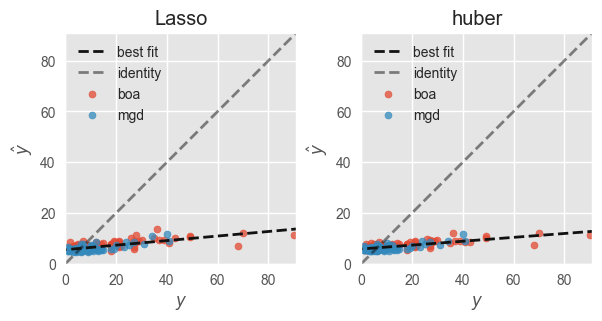

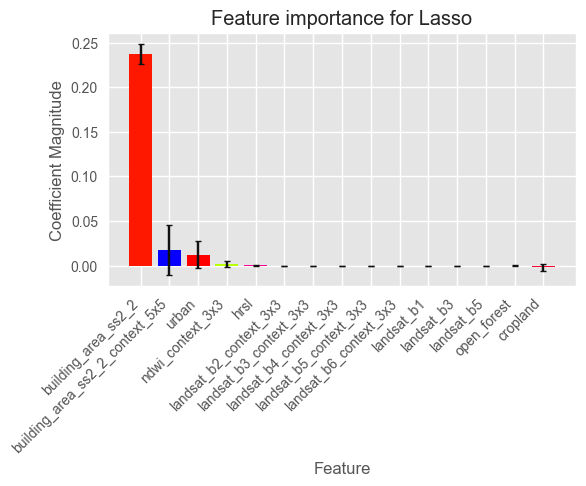

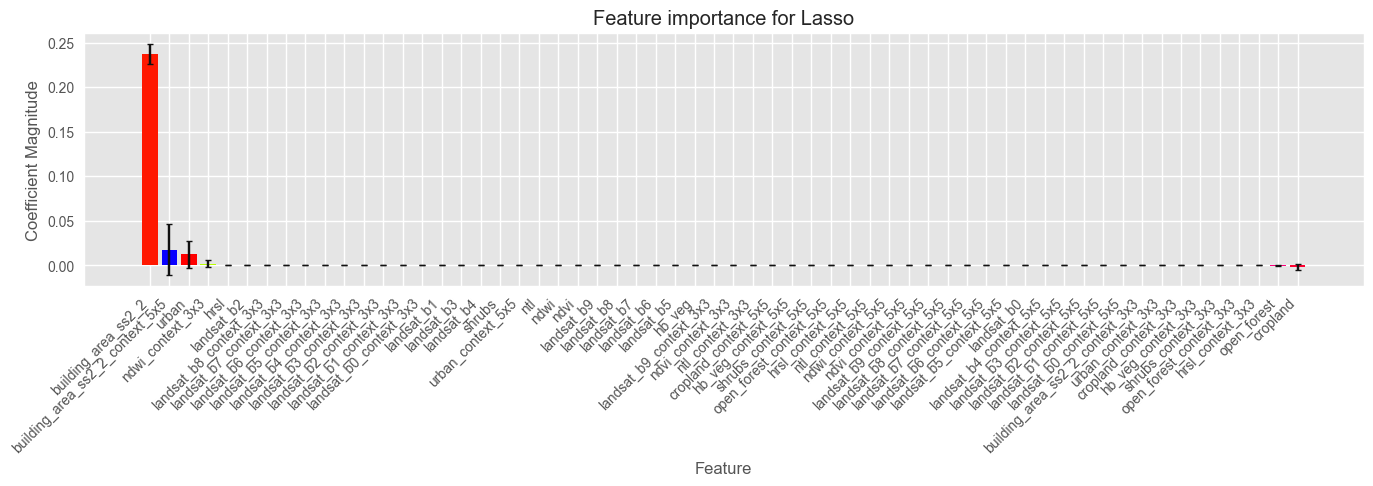

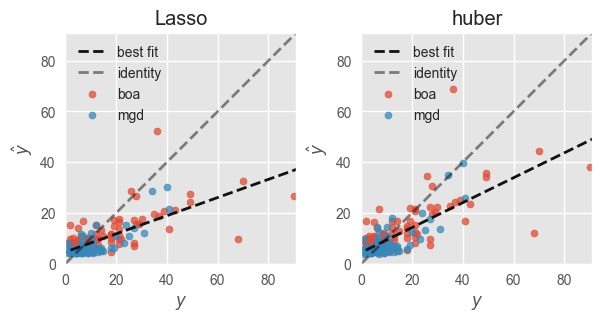

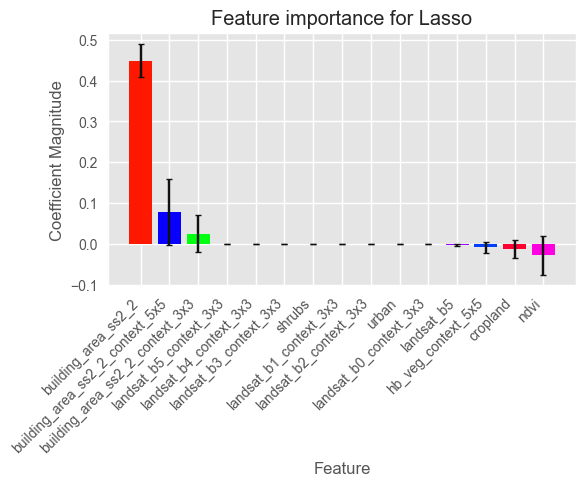

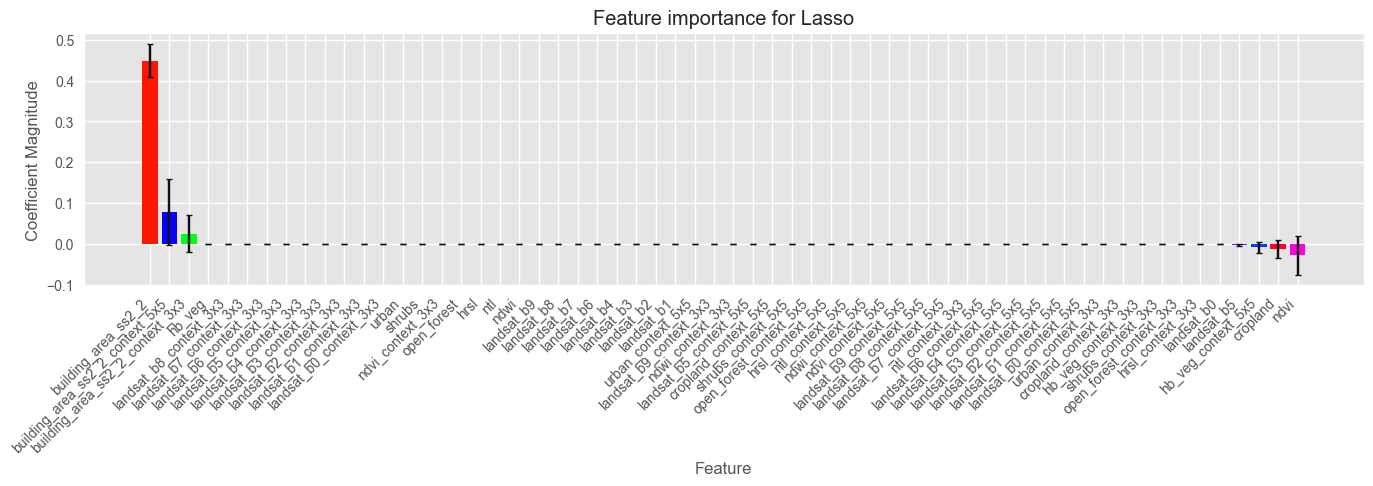

In [61]:
run_experiments(df,cvs,model_names,logs,[features],['./runs/huber/huber/'],target,prng)

In [63]:
features_list = [features_public,features_spacenet_only,features_spacesur_only,features_public_spacenet,features]
out_dir_list = ['./runs/new/public/','./runs/new/spacenet_only/','./runs/new/spacesur_only/','./runs/new/public_spacenet/','./runs/new/public_spacesur/']

In [64]:
# features_list = [features]
# out_dir_list = ['./runs/test/']


Training lasso

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.1}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.1}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.13673469387755102}

Plotting prediction error

(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 0.8)

Plotting feature importance


Training lasso

Training on 146 samples, validating on 53, 73/27 split
{'alpha': 0.1}
Training on 136 samples, validating on 63, 68/32 split
{'alpha': 0.1}
Training on 153 samples, validating on 46, 77/23 split
{'alpha': 0.1}
Training on 162 samples, validating on 37, 81/19 split
{'alpha': 0.1}

Plotting prediction error

(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 0.8)

Plotting feature importance



,0,1,2,3,4,5,6,7,8,9
0,0.00,51.3%,0.22,3.42,44.1%,0.42,44.8%,0.20,3.29,24.9%


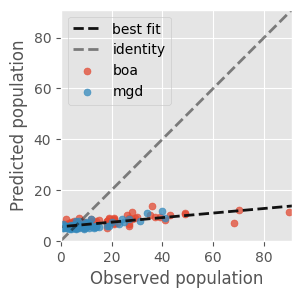

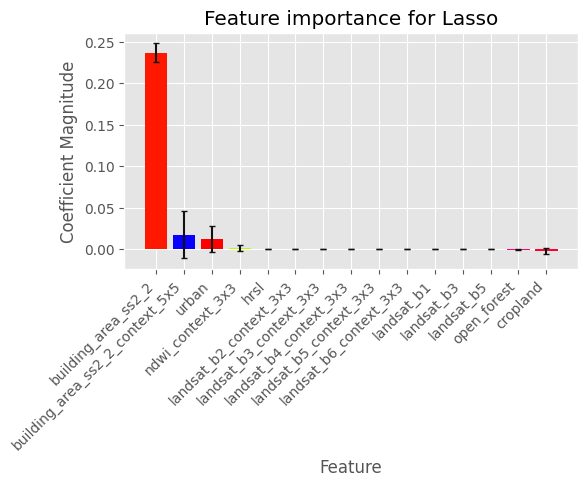

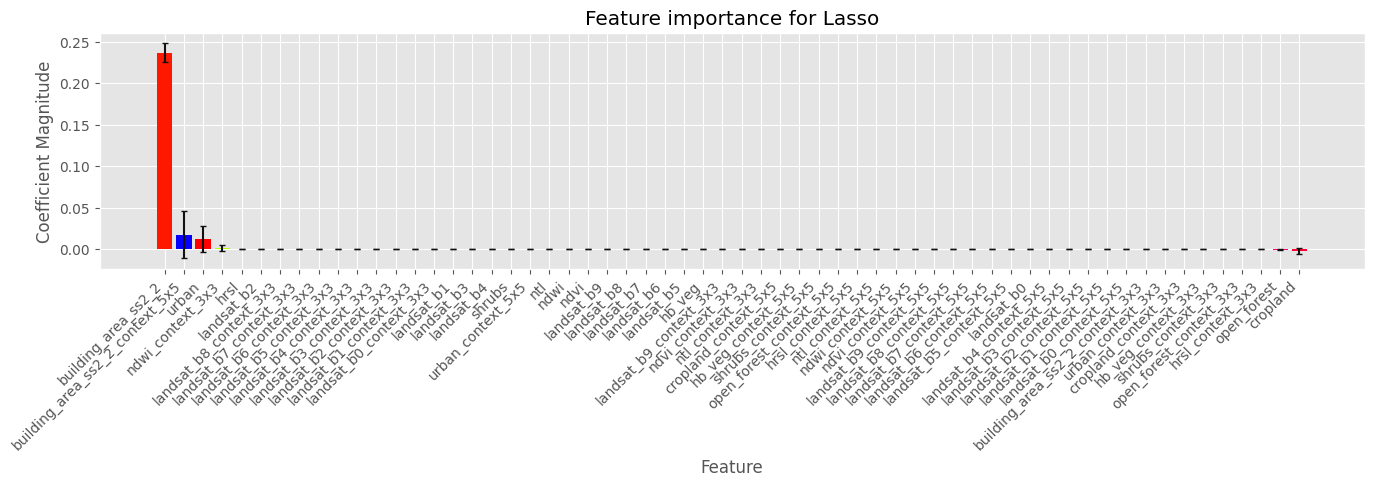

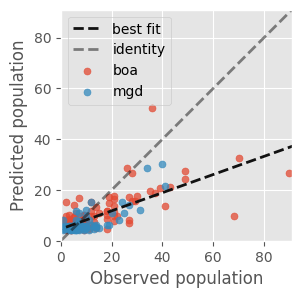

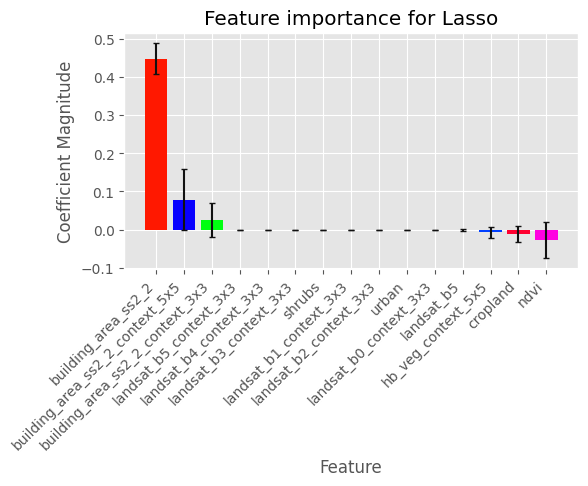

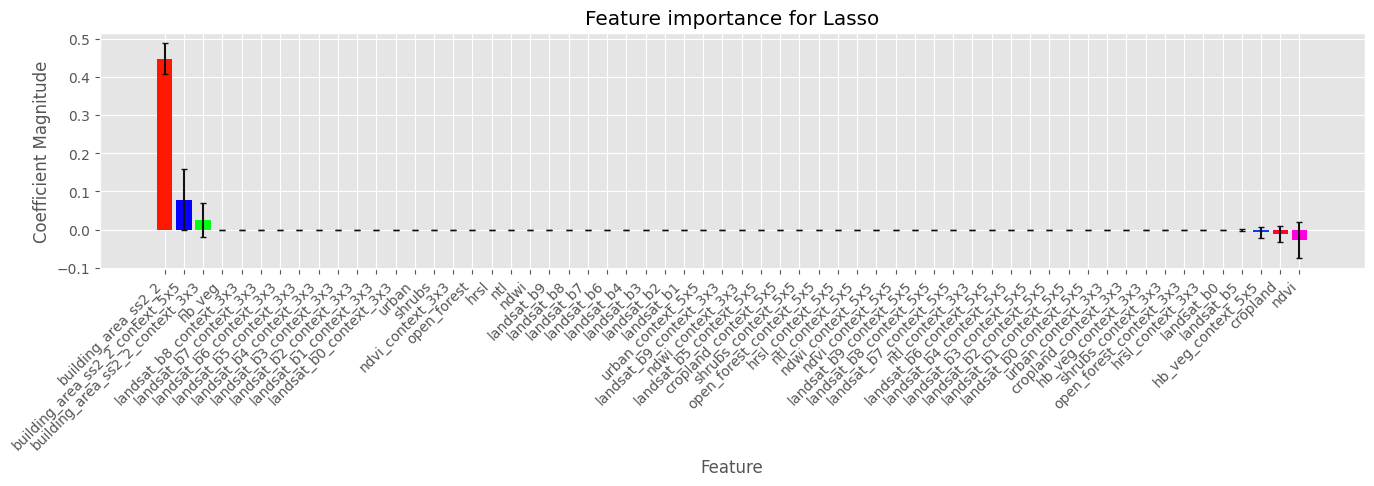

In [81]:
run_experiments(df,[cvs[0]],['lasso'],[True],[features],['./runs/lasso/lasso/'],target,prng)


Training huber

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.1, 'gamma': 0.01}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1, 'gamma': 1.0}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.1, 'gamma': 0.67}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.2, 'gamma': 0.78}

Plotting prediction error

(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 0.8)

Plotting feature importance


Training huber

Training on 146 samples, validating on 53, 73/27 split
{'alpha': 0.1, 'gamma': 0.01}
Training on 136 samples, validating on 63, 68/32 split
{'alpha': 0.1, 'gamma': 0.01}
Training on 153 samples, validating on 46, 77/23 split
{'alpha': 0.1, 'gamma': 0.01}
Training on 162 samples, validating on 37, 81/19 split
{'alpha': 0.1, 'gamma': 0.12}

Plotting prediction error

(0.8980392156862745, 0.8980392156862745, 0.8980392156862745, 0.8)

Plotting feature importance



,0,1,2,3,4,5,6,7,8,9
0,-0.01,49.9%,0.21,3.50,43.0%,0.53,42.1%,0.19,3.45,13.2%


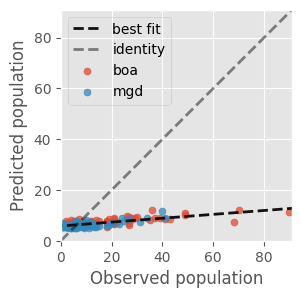

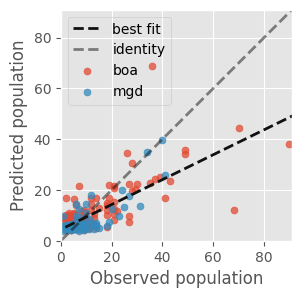

In [82]:
run_experiments(df,[cvs[1]],['huber'],[True],[features],['./runs/new/public_spacesur/'],target,prng)

(1, 10)

Training Lasso

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.19183673469387758}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.2836734693877551}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.1}
5
(0, 0, 5)

Plotting prediction error


Plotting feature importance


Training Lasso

Training on 220 samples, validating on 68, 76/24 split
{'alpha': 0.11836734693877551}
Training on 213 samples, validating on 75, 74/26 split
{'alpha': 0.1}
Training on 214 samples, validating on 74, 74/26 split
{'alpha': 0.13673469387755102}
Training on 217 samples, validating on 71, 75/25 split
{'alpha': 0.1}
5
(0, 5, 10)

Plotting prediction error


Plotting feature importance



,0,1,2,3,4,5,6,7,8,9
0,-0.07,53.7%,0.23,3.55,30.9%,0.32,43.1%,0.21,3.79,23.3%


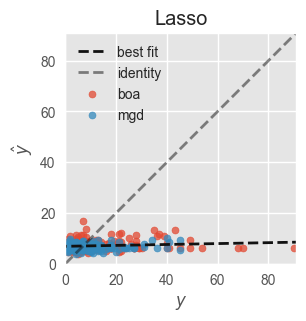

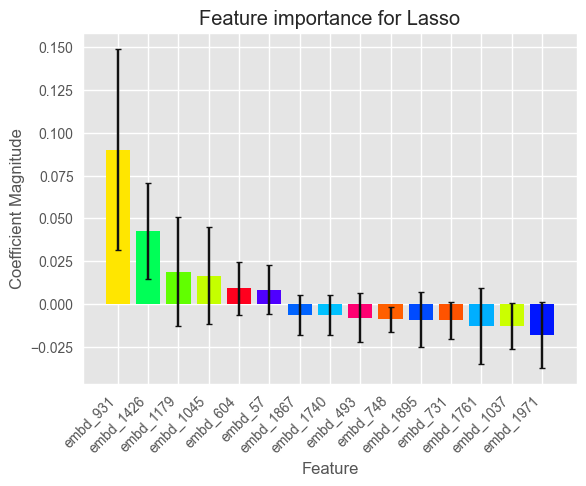

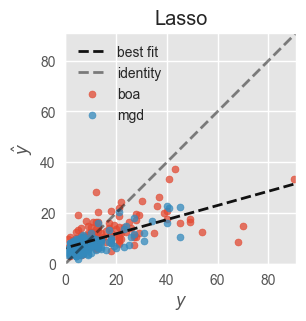

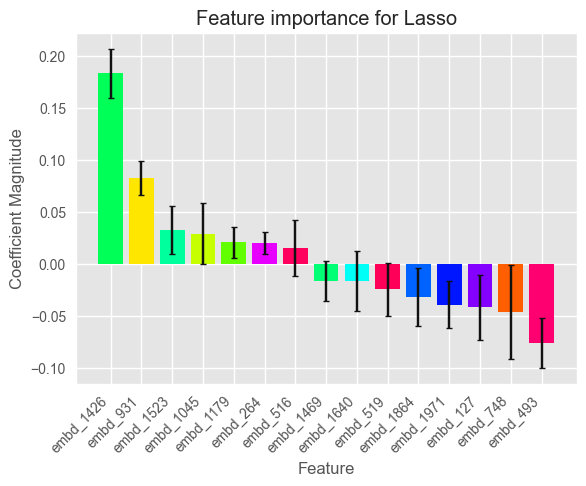

In [71]:
run_experiments(df,[cvs[2]],[model_names[2]],[logs[2]],[features_embeddings[0:n_features_embedding]],['./runs/resnetv2_101/'],target,prng,plot_full=False)

In [52]:
df_rem = df[df['outlier']==False]

In [53]:
y_true = df_rem[target].to_numpy()

In [56]:
lr = Lasso(max_iter=200)
reg_lr = GridSearchCV(lr,{'alpha':np.linspace(0.1,1,50)},scoring=make_scorer(meape,greater_is_better=False),cv=3,n_jobs=-1) # np.linspace(0.1,1,50)
y_pred_lr, models_lr = cross_val(reg_lr,df_rem,features,target,log=log,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
{'alpha': 0.13673469387755102}
Training on 213 samples, validating on 75, 74/26 split
{'alpha': 0.13673469387755102}
Training on 214 samples, validating on 74, 74/26 split
{'alpha': 0.1}
Training on 217 samples, validating on 71, 75/25 split
{'alpha': 0.11836734693877551}


In [61]:
df_rem['Lasso'] = y_pred_lr

C:\Users\Dumble\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


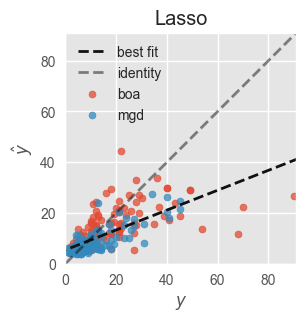

In [68]:
f,ax = plt.subplots(1,figsize=(3,3))
prediction_error(df_rem,true='pop',pred='Lasso',ax=ax,color=True) # plot
ax.set_title('Lasso')
f.savefig('./examples/predictions/lasso.pdf',bbox_inches='tight')

### Fit Poisson regression model

In [52]:
pr = PoissonRegressor(max_iter=200)
reg_pr = GridSearchCV(pr,{'alpha':np.linspace(0.1,1,50)},scoring=make_scorer(meape,greater_is_better=False),cv=3,n_jobs=-1)
y_pred_pr, models_pr = cross_val(reg_pr,df,features,target,log=False,return_models=True)

Training on 364 samples, validating on 110, 77/23 split
{'alpha': 0.3938775510204082}
Training on 349 samples, validating on 125, 74/26 split
{'alpha': 0.1}
Training on 358 samples, validating on 116, 76/24 split
{'alpha': 0.963265306122449}
Training on 351 samples, validating on 123, 74/26 split
{'alpha': 0.3387755102040817}


In [59]:
y_true = df[df['outlier']==False]['pop'].values

In [60]:
from sklearn.dummy import DummyRegressor
dr = DummyRegressor(strategy='mean')
reg_dr = GridSearchCV(dr,{},scoring=make_scorer(meape,greater_is_better=False),cv=3,n_jobs=-1)
y_pred_dr, models_dr = cross_val(reg_dr,df[df['outlier']==False],features,target,log=False,return_models=True)

Training on 146 samples, validating on 53, 73/27 split
{}
Training on 136 samples, validating on 63, 68/32 split
{}
Training on 153 samples, validating on 46, 77/23 split
{}
Training on 162 samples, validating on 37, 81/19 split
{}


In [61]:
print(f'{r2_score(y_true,y_pred_dr):0.2f} & {meape(y_true,y_pred_dr)*100:0.2f}% & {ameape(y_true,y_pred_dr):0.2f} & {median_absolute_error(y_true,y_pred_dr):0.2f} & {aggregate_percent_error(y_true,y_pred_dr)*100:0.2f}%')

-0.12 & 76.45% & 0.41 & 7.57 & 1.68%


In [82]:
dr = DummyRegressor(strategy='mean')
reg_dr = GridSearchCV(dr,{},scoring=make_scorer(meape,greater_is_better=False),cv=3,n_jobs=-1)
y_pred_dr, models_dr = cross_val(reg_dr,df[(df['outlier']==False)],features,target,log=False,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
{}
Training on 213 samples, validating on 75, 74/26 split
{}
Training on 214 samples, validating on 74, 74/26 split
{}
Training on 217 samples, validating on 71, 75/25 split
{}


In [89]:
y_true = df[(df['outlier']==False)][target].values

In [90]:
print(f'{r2_score(y_true,y_pred_dr):0.2f} & {meape(y_true,y_pred_dr)*100:0.2f}% & {ameape(y_true,y_pred_dr):0.2f} & {median_absolute_error(y_true,y_pred_dr):0.2f} & {aggregate_percent_error(y_true,y_pred_dr)*100:0.2f}%')

-0.09 & 65.00% & 0.39 & 7.81 & 0.42%


In [46]:
#bands = [(0,5),(5,15),(15,30),(30,50),(50,100)]
bands = [(0,10),(10,30),(30,100)]
accuracy(y_true,y_pred_pr,bands)

0.7013888888888888

### Fit random forest regression model

In [47]:
rf = RandomForestRegressor(n_jobs=-1,random_state=prng)
param_grid = {'n_estimators': list(range(100,1200,200)), # list(range(200,1200,200)
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}
reg_rf = GridSearchCV(rf,param_grid,scoring=make_scorer(meape,greater_is_better=False),cv=3,verbose=0,n_jobs=-1)
y_pred_rf, models_rf = cross_val(reg_rf,df,features,target,log=log,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
{'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Training on 213 samples, validating on 75, 74/26 split
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1100}
Training on 214 samples, validating on 74, 74/26 split
{'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1100}
Training on 217 samples, validating on 71, 75/25 split
{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}


In [48]:
#bands = [(0,5),(5,15),(15,30),(30,50),(50,100)]
bands = [(0,10),(10,30),(30,100)]
accuracy(y_true,y_pred_rf,bands)

0.7534722222222222

In [49]:
gp = GaussianProcessRegressor(kernel=ConstantKernel(1.0) * RBF(length_scale=np.full((features_gaussian.shape[0],1),1.0)))
param_grid = {}
reg_gp = GridSearchCV(gp,param_grid,scoring=make_scorer(meape,greater_is_better=False),cv=3,verbose=0,n_jobs=-1)
y_pred_gp, models_gp = cross_val(reg_gp,df,features_gaussian,target,log=log,return_models=True)

Training on 220 samples, validating on 68, 76/24 split
{}
Training on 213 samples, validating on 75, 74/26 split
{}
Training on 214 samples, validating on 74, 74/26 split
{}
Training on 217 samples, validating on 71, 75/25 split
{}


### Define dummy predictions

In [50]:
y_pred_dummy = np.full(y_true.shape[0],7)

### Update dataframe

In [51]:
df['GLM (Poisson)'] = y_pred_pr
df['Random Forest'] = y_pred_rf
df['Gaussian Process'] = y_pred_gp

## Evaluate Estimates

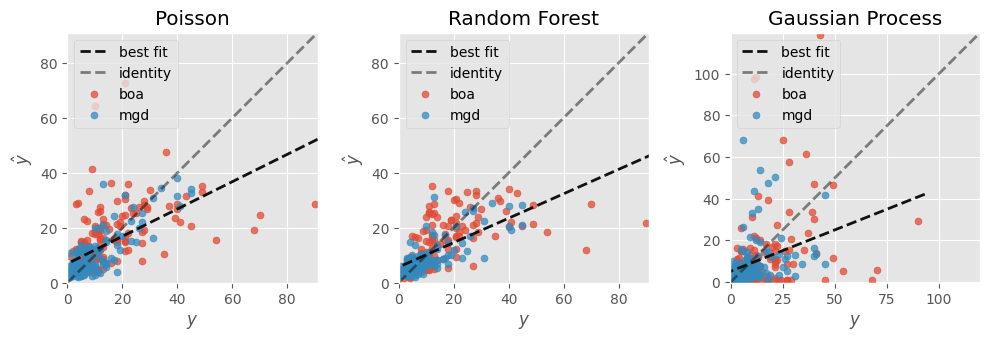

In [64]:
plt.style.use('ggplot')

f, axarr = plt.subplots(1,3,figsize=(10,5))
prediction_error(df,true='pop',pred='GLM (Poisson)',ax=axarr[0],color=True) # plot
axarr[0].set_title("Poisson")

prediction_error(df,true='pop',pred='Random Forest',ax=axarr[1],color=True) # plot
axarr[1].set_title("Random Forest")

prediction_error(df,true='pop',pred='Gaussian Process',ax=axarr[2],color=True) # plot
axarr[2].set_title("Gaussian Process")

f.tight_layout()
f.savefig('./test.pdf')

In [57]:
# f.tight_layout(pad=1.2)
# f.savefig('./examples/predictions/public_only.pdf')

In [65]:
tab = get_table(df,['GLM (Poisson)','Random Forest','Gaussian Process'])

In [66]:
print(tab)

\begin{table}
\centering
\caption{Model performance}
\begin{tabular}{lllll}
\toprule
            Model &   \$R\textasciicircum 2\$ & \$MeAPE\$ & \$MAE\$ & \$AgPE\$ \\
\midrule
    GLM (Poisson) &   0.298 &   42.4\% &  3.71 &  4.34\% \\
    Random Forest &   0.438 &   36.4\% &  3.14 &  10.7\% \\
 Gaussian Process &  -0.744 &   62.3\% &  4.96 &    20\% \\
\bottomrule
\end{tabular}
\end{table}



In [60]:
df['pop_pred'] = y_pred_pr

In [61]:
pop_boa = np.sum(df[df['roi']=='boa']['pop'])
pop_mgd = np.sum(df[df['roi']=='mgd']['pop'])
print(pop_boa)
print(pop_mgd)

2352.0
1314.0


In [62]:
pop_pred_boa = np.sum(df[df['roi']=='boa']['pop_pred'])
pop_pred_mgd = np.sum(df[df['roi']=='mgd']['pop_pred'])
print(pop_pred_boa)
print(pop_pred_mgd)

2496.6358924665346
1319.7941353586841


In [63]:
boa_error = abs((pop_pred_boa - pop_boa)/pop_pred_boa)
mgd_error = abs((pop_pred_mgd - pop_mgd)/pop_pred_mgd)
print(boa_error)
print(mgd_error)

0.05793231319911955
0.0043901811679966495


In [71]:
cmap = plt.cm.get_cmap('hsv')
n_features = features.shape[0]
#colors = np.array([cmap((0.7+(i)/n_features)%1) for i in range(n_features)])
colors = np.array([cmap((0.5+(i)/n_features)%1) for i in range(n_features)])

In [65]:
def feature_importance(models,features,colors):
    f, ax = plt.subplots(figsize=(10,5))
    importances = []
    
    model_type = type(models[0]).__name__
    y_label = ''
    if model_type == 'RandomForestRegressor':
        importances = np.array([model.feature_importances_ for model in models])
        y_label = 'Importance'
    elif model_type == 'PoissonRegressor':
        importances = np.array([model.coef_ for model in models])
        y_label = 'Coefficient Magnitude'
    else:
        print("Unsuported model")
        return
    
    n = np.arange(importances.shape[1])
    
    means = np.mean(importances,axis=0)
    stds = np.std(importances,axis=0)
    
    idxs = np.argsort(means,axis=0)[::-1]
    means = means[idxs]
    stds = stds[idxs]
    labels = features[idxs]
    colors_sorted = colors[idxs]
    
    ax.bar(n,means,yerr=stds,color=colors_sorted,error_kw={'capsize':2.5,'capthick':1.0})
    ax.set_xticks(n)
    ax.set_xticklabels(labels,rotation=90)
    
    ax.set_ylabel(y_label)
    ax.set_xlabel('Feature')
    
    ax.set_title(f'Feature importance for {model_type}')
    
    return (f,ax)
        

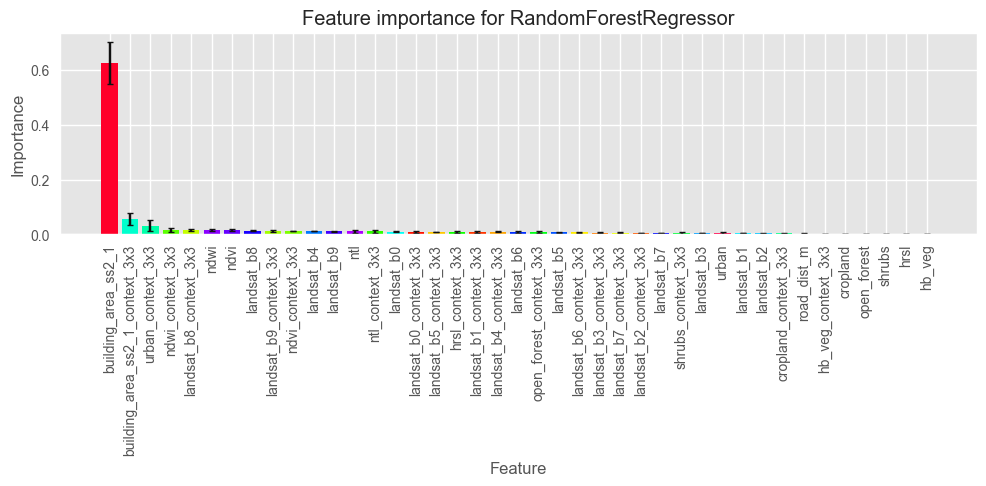

In [72]:
f,ax = feature_importance(models_rf,features,get_colors())
f.tight_layout(pad=1.2)
f.savefig('./examples/importance/rf_importance_3x3.pdf')

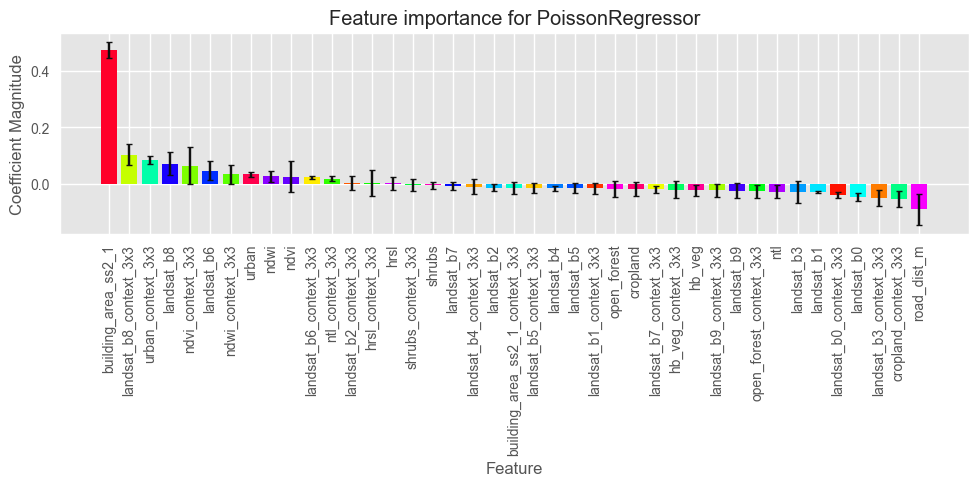

In [73]:
f,ax = feature_importance(models_pr,features,colors)
f.tight_layout(pad=1.2)
f.savefig('./examples/importance/pr_importance_3x3.pdf')

In [68]:
# f, ax = plt.subplots(figsize=(10,10))
# prediction_error(y_true,y_pred_pr,ax=ax,df=df,images=True,tiles_path=tiles_path) # plot
# ax.set_title("Poisson")
# f.tight_layout()
#f.savefig('image_error_plot_large.png',dpi=1000)

In [55]:
# f, ax = plt.subplots(figsize=(10,10))
# prediction_error(y_true,y_pred_pr,ax=ax,df=df,images=True,buildings=True,tiles_path=tiles_path) # plot
# ax.set_title("Poisson")
# f.tight_layout()
#f.savefig('building_error_plot_large.png',dpi=1000)